<a href="https://colab.research.google.com/github/shohan007/DIS-soft-sensing-benchmarking-with-SVR-ANN/blob/main/SVM_and_ANN_one_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#One-Step Univariate Forecasting function
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('DeltaP%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('DeltaP%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('DeltaP%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
#Data preprocessing
dataset=pd.read_excel('/content/Updated database day 1-11 with temp (2).xlsx')
cleaned_df=dataset.iloc[:,1:16]
cleaned_df=pd.DataFrame(cleaned_df)
cleaned_df.head(10)

,Sample,Day,Probe Temperature,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz,DeltaP
0,1,1,19.97,-0.141,-0.343,-0.929,-1.064,-1.174,-1.397,-1.451,-1.561,-1.457,-1.647,-1.520,1.506
1,1,1,19.99,-0.281,-0.420,-1.021,-1.100,-1.294,-1.400,-1.481,-1.525,-1.437,-1.554,-1.511,1.273
2,1,1,20.01,-0.209,-0.259,-1.063,-1.027,-1.183,-1.424,-1.557,-1.593,-1.482,-1.574,-1.499,1.384
3,1,1,20.03,-0.164,-0.628,-0.890,-0.952,-1.262,-1.397,-1.523,-1.581,-1.446,-1.680,-1.589,1.516
4,1,1,20.03,-0.178,-0.495,-0.882,-0.999,-1.264,-1.400,-1.487,-1.571,-1.522,-1.597,-1.606,1.428
5,1,1,20.03,-0.063,-0.509,-1.184,-1.053,-1.405,-1.480,-1.505,-1.590,-1.493,-1.635,-1.541,1.572
6,1,1,20.03,-0.261,-0.318,-1.051,-1.056,-1.222,-1.405,-1.484,-1.598,-1.525,-1.674,-1.587,1.413
7,1,1,20.03,0.077,-0.334,-1.173,-1.150,-1.172,-1.428,-1.576,-1.564,-1.532,-1.605,-1.593,1.682
8,1,1,20.02,-0.148,-0.487,-1.044,-0.988,-1.235,-1.473,-1.497,-1.590,-1.516,-1.706,-1.583,1.558
9,1,1,20.02,-0.038,-0.354,-1.186,-1.174,-1.342,-1.440,-1.602,-1.534,-1.547,-1.676,-1.596,1.638


In [5]:
#individual dataset for each scenario
scenario_1_df=cleaned_df[cleaned_df['Sample']==1]
scenario_2_df=cleaned_df[cleaned_df['Sample']==5]
scenario_3_df_1=cleaned_df[cleaned_df['Sample']==7]
scenario_3_df_2=cleaned_df[cleaned_df['Sample']==12]

#finding out the index for the missing values to be predicted
scenario1_day_10_sample_1=scenario_1_df[scenario_1_df['Day']==10][scenario_1_df['Sample']==1].index
scenario1_day_11_sample_1=scenario_1_df[scenario_1_df['Day']==11][scenario_1_df['Sample']==1].index
scenario2_day_5_sample_5= scenario_2_df[scenario_2_df['Day']==5][scenario_2_df['Sample']==5].index
scenario2_day_9_sample_5= scenario_2_df[scenario_2_df['Day']==9][scenario_2_df['Sample']==5].index
scenario3_day_8_sample_7= scenario_3_df_1[scenario_3_df_1['Day']==8][scenario_3_df_1['Sample']==7].index
scenario3_day_3_sample_12= scenario_3_df_2[scenario_3_df_2['Day']==3][scenario_3_df_2['Sample']==12].index

#dataset without the testing data
#Scenario 1
scenario_1= scenario1_day_10_sample_1.append(scenario1_day_11_sample_1).values
scenario_1_df.drop(scenario_1, inplace=True)
scenario_1_df=pd.DataFrame(scenario_1_df['DeltaP'])
#scenario_1_df

#Scenario 2
scenario_2= scenario2_day_5_sample_5.append(scenario2_day_9_sample_5).values
scenario_2_df.drop(scenario_2, inplace=True)
scenario_2_df=pd.DataFrame(scenario_2_df['DeltaP'])
#scenario_2_df

#Scenario 3
scenario_3_s7= scenario3_day_8_sample_7.values
scenario_3_df_1.drop(scenario_3_s7, inplace=True)
scenario_3_df_1=pd.DataFrame(scenario_3_df_1['DeltaP'])
#scenario_3_df_1

scenario_3_s12= scenario3_day_3_sample_12.values
scenario_3_df_2.drop(scenario_3_s12, inplace=True)
scenario_3_df_2=pd.DataFrame(scenario_3_df_2['DeltaP'])
#scenario_3_df_2


#SVM

In [6]:
# Scenario 1 (Sample 1, day 10,11 data missing)
test_scenario_1=pd.DataFrame(cleaned_df.iloc[scenario_1,-1])
final_data_scenario_1=scenario_1_df.append(test_scenario_1)

data = series_to_supervised(final_data_scenario_1,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
data

#Training Test split
X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

X_train=X.iloc[1:-40,:].values
y_train=y.iloc[1:-40,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-40,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph

#Hyper Parameter Tuning with cross validation

parameters = {'kernel':['linear', 'rbf'],'C':[0.1, .5, 1, 5, 10], 'epsilon':[0.01, 0.1,0.2,0.5,1], 'gamma': [ 0.001, 0.001, 0.1, 0.5, 1, 5]}
# Create a based model
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = parameters, scoring='neg_root_mean_squared_error',
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 1 (Sample 1, day 10,11 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

 Scenario 1 (Sample 1, day 10,11 data missing): 
 
MSE Test:  0.00790956205026938
MSE Train:  0.011306822665845763
RMSE Test:  0.08893571864144001
RMSE Train:  0.10633354440554384
nRMSE Test:  0.17499325868606963
nRMSE Train:  0.10633354440554384


In [7]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.072 (0.008)


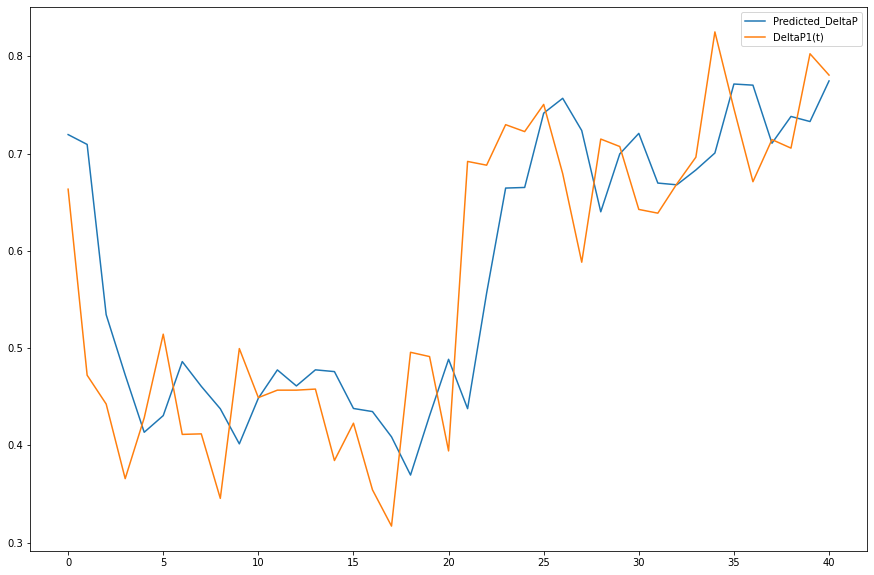

In [8]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

In [9]:
#Scenario 2 (Sample 5, day 5,9 data missing)

test_scenario_2=pd.DataFrame(cleaned_df.iloc[scenario_2,-1])
final_data_scenario_2=scenario_2_df.append(test_scenario_2)

data = series_to_supervised(final_data_scenario_2,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
data

X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

#Training Test split


X_train=X.iloc[1:-40,:].values
y_train=y.iloc[1:-40,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-40,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph


#Hyper Parameter Tuning with cross validation

parameters = {'kernel':['linear', 'rbf'],'C':[0.1, .5, 1, 5, 10], 'epsilon':[0.01, 0.1,0.2,0.5,1], 'gamma': [ 0.001, 0.001, 0.1, 0.5, 1, 5]}
# Create a based model
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = parameters, scoring='neg_root_mean_squared_error',
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 1 (Sample 1, day 10,11 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

 Scenario 1 (Sample 1, day 10,11 data missing): 
 
MSE Test:  0.0067674275706759
MSE Train:  0.01497916327915436
RMSE Test:  0.08226437607297524
RMSE Train:  0.1223893920205275
nRMSE Test:  0.21134027995316654
nRMSE Train:  0.1223893920205275


In [10]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.078 (0.011)


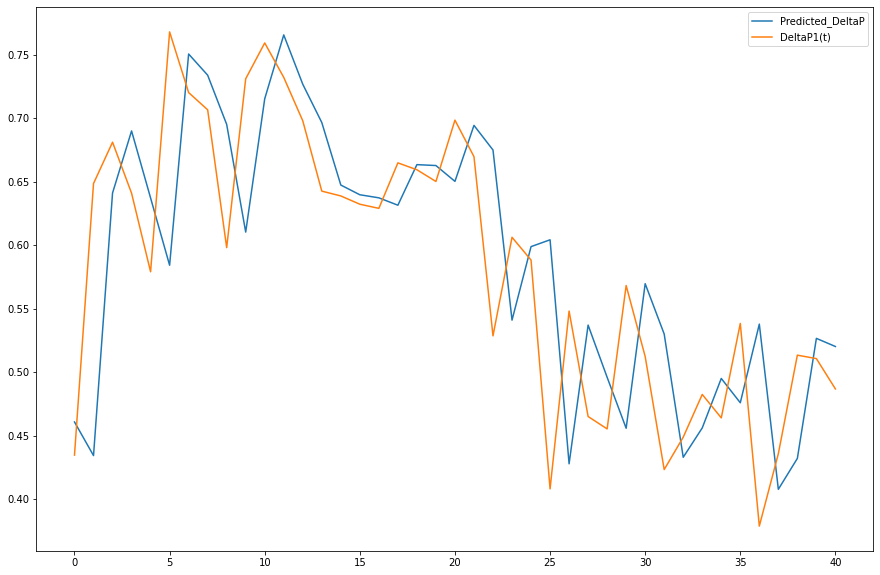

In [11]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

In [12]:
#scenario 3 (Sample 7 Day 8 data missing, Sample 12 Day 3 data missing)

#scenario 3 sample 7

test_scenario_3_s7=pd.DataFrame(cleaned_df.iloc[scenario_3_s7,-1])
final_data_scenario_3_s7=scenario_3_df_1.append(test_scenario_3_s7)

data = series_to_supervised(final_data_scenario_3_s7,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
#data

X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

#Training Test split


X_train=X.iloc[1:-20,:].values
y_train=y.iloc[1:-20,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-20,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph


#Hyper Parameter Tuning with cross validation

parameters = {'kernel':['linear', 'rbf'],'C':[0.1, .5, 1, 5, 10], 'epsilon':[0.01, 0.1,0.2,0.5,1], 'gamma': [ 0.001, 0.001, 0.1, 0.5, 1, 5]}
# Create a based model
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = parameters, scoring='neg_root_mean_squared_error',
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 1 (Sample 1, day 10,11 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.001,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

 Scenario 1 (Sample 1, day 10,11 data missing): 
 
MSE Test:  0.0024951291540474033
MSE Train:  0.011937685712320132
RMSE Test:  0.049951267792193256
RMSE Train:  0.10925971678674685
nRMSE Test:  0.35308295338594625
nRMSE Train:  0.10925971678674685


In [13]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.067 (0.009)


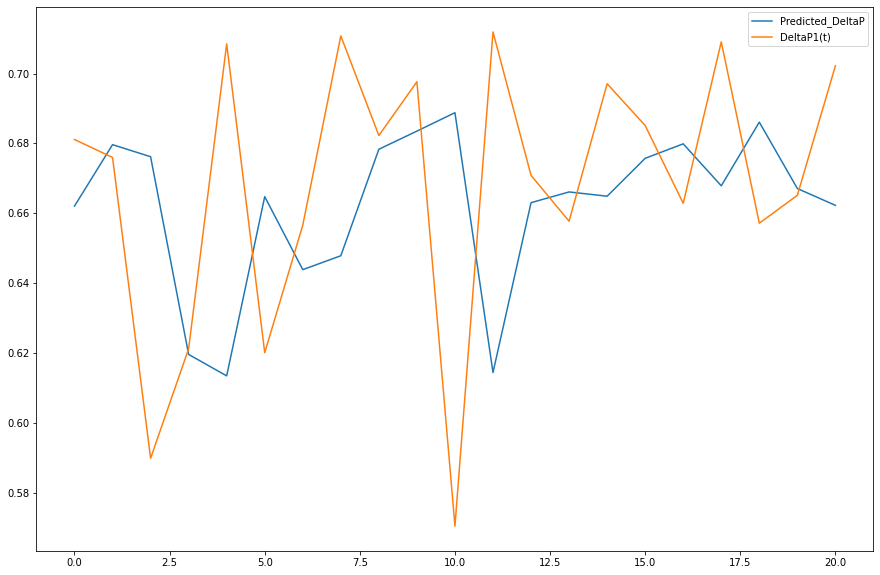

In [14]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

In [15]:
#scenario 3 (Sample 7 Day 8 data missing, Sample 12 Day 3 data missing)

#scenario 3 sample 12

test_scenario_3_s12=pd.DataFrame(cleaned_df.iloc[scenario_3_s12,-1])
final_data_scenario_3_s12=scenario_3_df_2.append(test_scenario_3_s12)

data = series_to_supervised(final_data_scenario_3_s12,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
#data

X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

#Training Test split


X_train=X.iloc[1:-20,:].values
y_train=y.iloc[1:-20,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-20,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph


#Hyper Parameter Tuning with cross validation

parameters = {'kernel':['linear', 'rbf'],'C':[0.1, .5, 1, 5, 10], 'epsilon':[0.01, 0.1,0.2,0.5,1], 'gamma': [ 0.001, 0.001, 0.1, 0.5, 1, 5]}
# Create a based model
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = parameters, scoring='neg_root_mean_squared_error',
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 1 (Sample 1, day 10,11 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)   

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

 Scenario 1 (Sample 1, day 10,11 data missing): 
 
MSE Test:  0.003209937573277428
MSE Train:  0.011019602166567909
RMSE Test:  0.056656310974836935
RMSE Train:  0.1049742928843434
nRMSE Test:  0.3654234036577709
nRMSE Train:  0.1049742928843434


In [16]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.068 (0.011)


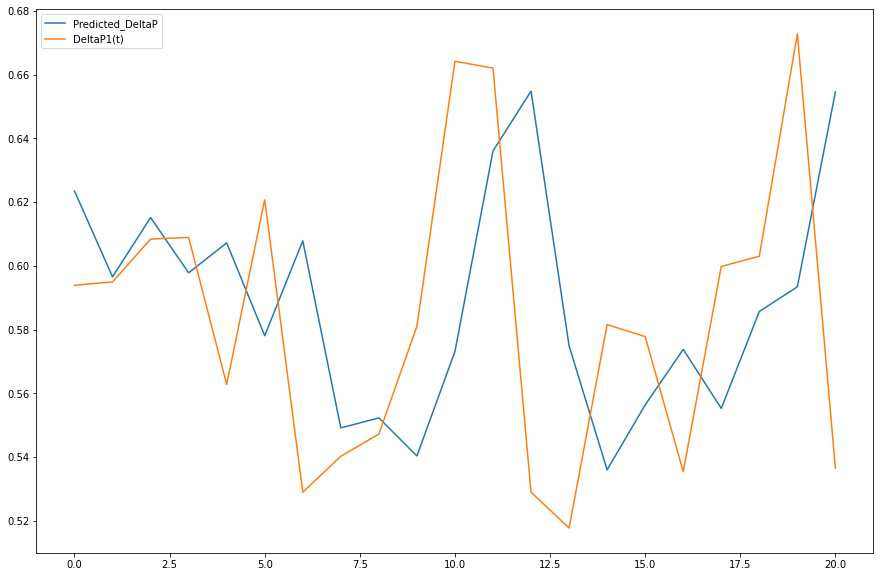

In [17]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

##ANN

In [18]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from numpy import asarray
from sklearn.datasets import make_regression

In [ ]:
'''

# use mlp for prediction on multi-output regression

# get the model
def get_model(learning_rate=0.01, neurons=1):

  model = Sequential()
  model.add(Dense(neurons, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(12, kernel_initializer='he_uniform', activation='relu')) 
  model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
  optimizer = keras.optimizers.Adam(lr=learning_rate)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

# define the grid search parameters
batch_size = [60,  100]
epochs = [100, 500, 1000]
#optimizer = ['SGD','Adam', 'Adamax', 'Nadam']
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
neurons = [5, 10, 12, 15, 16, 20]

model = KerasRegressor(build_fn=get_model, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X, y)

# get model
#model = get_model(n_inputs, n_outputs)

# fit the model on all data
#model.fit(X_train, y_train, verbose=0, epochs=5000)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#####  -0.010898 using {'batch_size': 100, 'epochs': 500, 'learning_rate': 0.01, 'neurons': 16} ######


'''


'\n\n# use mlp for prediction on multi-output regression\n\n# get the model\ndef get_model(learning_rate=0.01, neurons=1):\n\n  model = Sequential()\n  model.add(Dense(neurons, input_dim=n_inputs, kernel_initializer=\'he_uniform\', activation=\'relu\'))\n  model.add(Dense(12, kernel_initializer=\'he_uniform\', activation=\'relu\')) \n  model.add(Dense(n_outputs, kernel_initializer=\'he_uniform\'))\n  optimizer = keras.optimizers.Adam(lr=learning_rate)\n  model.compile(loss=\'mean_squared_error\', optimizer=optimizer)\n  return model\n \n# load dataset\nn_inputs, n_outputs = X.shape[1], y.shape[1]\n\n# define the grid search parameters\nbatch_size = [60,  100]\nepochs = [100, 500, 1000]\n#optimizer = [\'SGD\',\'Adam\', \'Adamax\', \'Nadam\']\nlearning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\n#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]\nneurons = [5, 10, 12, 15, 16, 20]\n\nmodel = KerasRegressor(build_fn=get_model, verbose=0)\nparam_grid = dict(batch_size=batch_size, epochs=epochs, learning_r

In [19]:
# Scenario 1 (Sample 1, day 10,11 data missing)
test_scenario_1=pd.DataFrame(cleaned_df.iloc[scenario_1,-1])
final_data_scenario_1=scenario_1_df.append(test_scenario_1)

data = series_to_supervised(final_data_scenario_1,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
data

#Training Test split
X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

X_train=X.iloc[1:-40,:].values
y_train=y.iloc[1:-40,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-40,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph

# use mlp for prediction on multi-output regression

# get the model
def get_model(learning_rate=0.01, neurons=1):

  model = Sequential()
  model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(12, kernel_initializer='he_uniform', activation='relu')) 
  model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
  optimizer = keras.optimizers.Adam(lr=0.01)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

# define the grid search parameters
batch_size = [20,60, 100]
epochs = [500, 1000]


model = KerasRegressor(build_fn=get_model, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search = grid.fit(X_train, y_train)

#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 1 (Sample 1, day 10,11 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)



 Scenario 1 (Sample 1, day 10,11 data missing): 
 
MSE Test:  0.012880944302284756
MSE Train:  0.009509631878455499
RMSE Test:  0.11349424788192905
RMSE Train:  0.097517341424259
nRMSE Test:  0.2233155427579704
nRMSE Train:  0.097517341424259


In [20]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.083 (0.011)


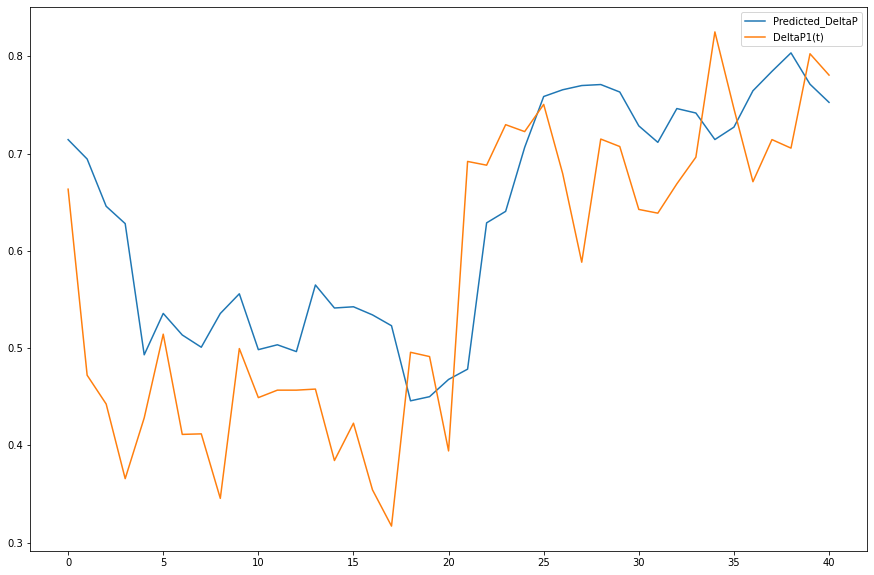

In [21]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

In [22]:
#Scenario 2 (Sample 5, day 5,9 data missing)

test_scenario_2=pd.DataFrame(cleaned_df.iloc[scenario_2,-1])
final_data_scenario_2=scenario_2_df.append(test_scenario_2)

data = series_to_supervised(final_data_scenario_2,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
#data

X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

#Training Test split

X_train=X.iloc[1:-40,:].values
y_train=y.iloc[1:-40,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-40,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph


# use mlp for prediction on multi-output regression

# get the model
def get_model(learning_rate=0.01, neurons=1):

  model = Sequential()
  model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(12, kernel_initializer='he_uniform', activation='relu')) 
  model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
  optimizer = keras.optimizers.Adam(lr=0.01)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

# define the grid search parameters
batch_size = [20,60, 100]
epochs = [500, 1000]


model = KerasRegressor(build_fn=get_model, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search = grid.fit(X_train, y_train)

#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 2 (Sample 5, day 5,9 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)


 Scenario 2 (Sample 5, day 5,9 data missing): 
 
MSE Test:  0.008962454029320142
MSE Train:  0.011881083124008774
RMSE Test:  0.09467023835039258
RMSE Train:  0.10900038130212561
nRMSE Test:  0.2432114073102136
nRMSE Train:  0.10900038130212561


In [23]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.098 (0.024)


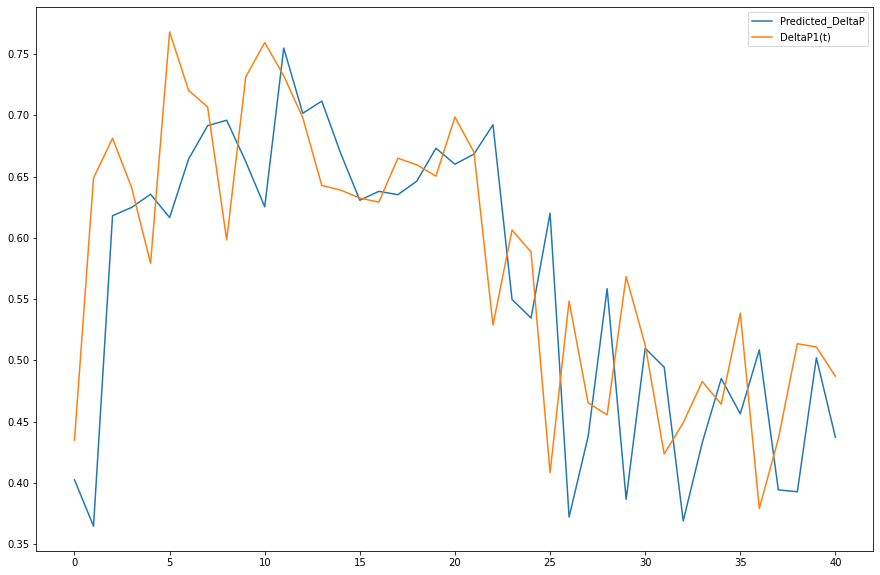

In [24]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

In [25]:
#Scenario 3 (Sample 7 Day 8 data missing, Sample 12 Day 3 data missing)

#scenario 3 sample 7

test_scenario_3_s7=pd.DataFrame(cleaned_df.iloc[scenario_3_s7,-1])
final_data_scenario_3_s7=scenario_3_df_1.append(test_scenario_3_s7)

data = series_to_supervised(final_data_scenario_3_s7,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
#data

X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

X_train=X.iloc[1:-20,:].values
y_train=y.iloc[1:-20,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-20,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph


#data.head()

# use mlp for prediction on multi-output regression

# get the model
def get_model(learning_rate=0.01, neurons=1):

  model = Sequential()
  model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(12, kernel_initializer='he_uniform', activation='relu')) 
  model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
  optimizer = keras.optimizers.Adam(lr=0.01)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

# define the grid search parameters
batch_size = [20,60, 100]
epochs = [500, 1000]


model = KerasRegressor(build_fn=get_model, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search = grid.fit(X_train, y_train)

#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 3 (Sample 7 Day 8 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train)


 Scenario 3 (Sample 7 Day 8 data missing): 
 
MSE Test:  0.0029988417145213396
MSE Train:  0.009454852904914551
RMSE Test:  0.05476168107829908
RMSE Train:  0.09723606792191132
nRMSE Test:  0.3870855924607185
nRMSE Train:  0.09723606792191132


In [26]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.081 (0.010)


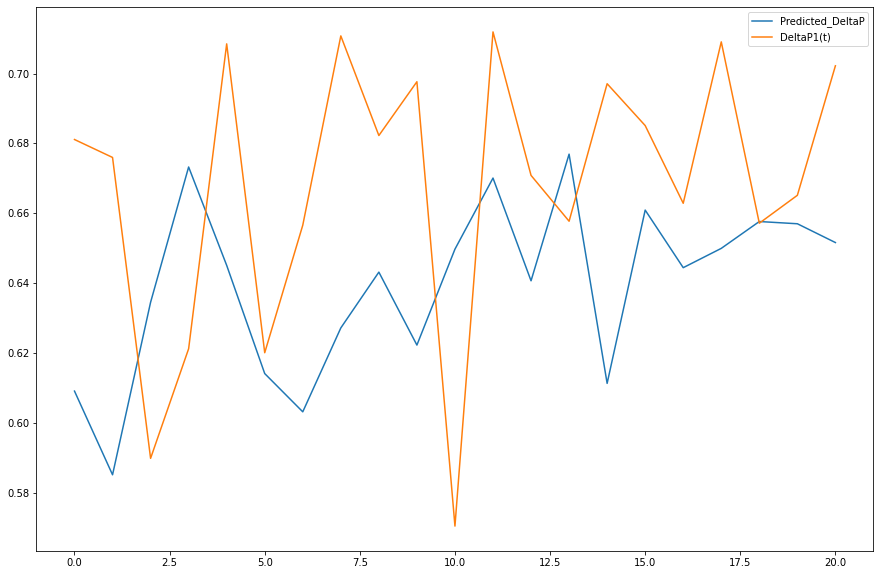

In [27]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));

In [28]:
#scenario 3 (Sample 7 Day 8 data missing, Sample 12 Day 3 data missing)

#scenario 3 sample 12

test_scenario_3_s12=pd.DataFrame(cleaned_df.iloc[scenario_3_s12,-1])
final_data_scenario_3_s12=scenario_3_df_2.append(test_scenario_3_s12)

data = series_to_supervised(final_data_scenario_3_s12,5)   # changing the numeric value changes the time lag difference (2-5 should be allowable as we are using maximum of 5 data from each day)
#print(data)
scaler= preprocessing.MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)
#data

X=data.iloc[:,1:-1]  
y=pd.DataFrame(data.iloc[:,-1]) #Last row as Y value

#Training Test split


X_train=X.iloc[1:-20,:].values
y_train=y.iloc[1:-20,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-20,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph


#data.head()

# use mlp for prediction on multi-output regression

# get the model
def get_model(learning_rate=0.01, neurons=1):

  model = Sequential()
  model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(12, kernel_initializer='he_uniform', activation='relu')) 
  model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
  optimizer = keras.optimizers.Adam(lr=0.01)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

# define the grid search parameters
batch_size = [20,60, 100]
epochs = [500, 1000]


model = KerasRegressor(build_fn=get_model, verbose=0)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search = grid.fit(X_train, y_train)

#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 
N = len(y_train)
mse_train=np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N
rmse_train = np.sqrt(np.sum((np.array(y_train_df).flatten() - (np.array(predictions_x).flatten()))**2)/N)
nRMSE_train=rmse_train/(np.array(y_train_df).max()-np.array(y_train_df).min())

print('\n Scenario 3 (Sample 12 Day 3 data missing): \n ')
print("MSE Test: ", mse_test)   
print("MSE Train: ", mse_train) 
print("RMSE Test: ", rmse_test) 
print("RMSE Train: ", rmse_train)
print("nRMSE Test: ", nRMSE_test)
print("nRMSE Train: ", nRMSE_train) 


 Scenario 3 (Sample 12 Day 3 data missing): 
 
MSE Test:  0.0033641765993236324
MSE Train:  0.007153268694305802
RMSE Test:  0.05800152238798247
RMSE Train:  0.08457699861254124
nRMSE Test:  0.374099784537021
nRMSE Train:  0.08457699861254124


In [29]:
#MAE With cross validation

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

svr=grid_search.best_estimator_

# evaluate the model and collect the scores
n_scores = cross_val_score(svr, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.080 (0.011)


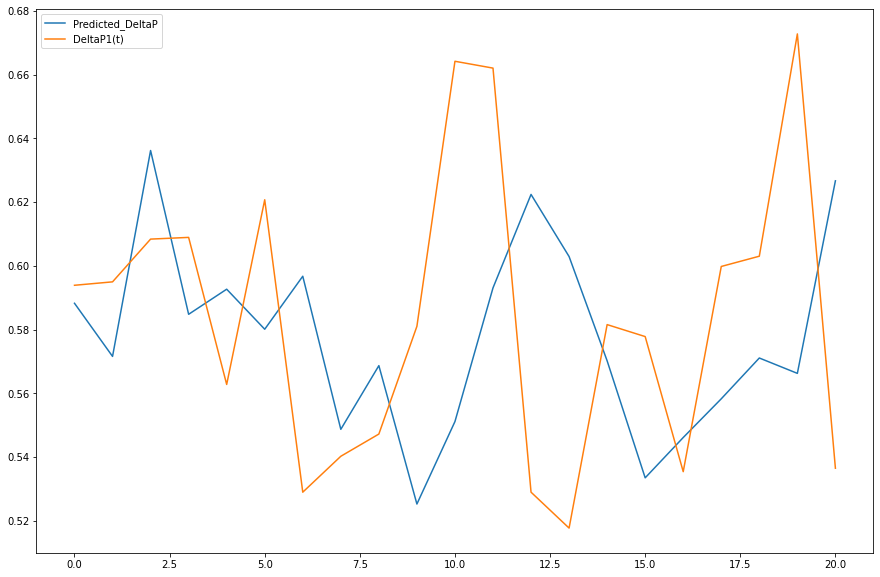

In [30]:
df_index = pd.merge(predictions_y, y_test_df, right_index=True, left_index=True)
df_index=df_index.reset_index(drop=True)
df_index
df_index.plot(figsize=(15,10));